In [1]:
import tensorflow as tf
sess = tf.InteractiveSession()

sess.config = tf.ConfigProto(log_device_placement=True)

%matplotlib inline

### Loading and investigating the data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


label : [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


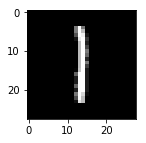

In [3]:
plt.rc('figure', figsize=(2, 2))
num_train = mnist.train.images.shape[0]
picked_idx = np.random.randint(0, num_train-1)
digi_rndm = mnist.train.images[picked_idx]
digi_label = mnist.train.labels[picked_idx]
digi_mat = digi_rndm.reshape(28, 28)
_=plt.imshow(digi_mat, cmap='gray')
print('label : {}'.format(digi_label))

### The structure of this convolutional neural network is shown as:

![graphs from tensorBoard](dnn.png)

In [4]:
# Define a function to register tensorboard monitor elements
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [5]:
# Define the parameters for the CNN
HEIGHT = 28
WIDTH = 28
CHANNEL = 1
NPIXELS = HEIGHT*WIDTH
NLABELS = 10

CONV_HEIGHT = 5
CONV_WIDTH = 5

POOL_HEIGHT = 2
POOL_WIDTH = 2

NCONV_LAYERS = 2
NCONV1 = 32
NCONV2 = 64

NDENSE = 1024

NBATCH = 200
PROB_DROPOUT = 0.5

FIN_HEIGHT = int(HEIGHT/(POOL_HEIGHT*NCONV_LAYERS))
FIN_WIDTH = int(WIDTH/(POOL_WIDTH*NCONV_LAYERS))

# Function to define the weights and their initial values
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Function to define the bias and their initial values
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Function to construct a 2D conv. layer
def conv2d(x, W):
    # x is the input tensor, W is the weight
    # strides of [batch, height, width, channel]. padding of 'SAME' to keep number of output nodes the same as input
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Function to make pooling
def max_pool_2x2(x):
    # ksize define the size of the pooling
    # strides with pool_height and pool_width ensure no overlap elements used
    return tf.nn.max_pool(x, ksize=[1, POOL_HEIGHT, POOL_WIDTH, 1],
                        strides=[1, POOL_HEIGHT, POOL_WIDTH, 1], padding='SAME')

with tf.name_scope('input'):
    # tensor dimension of [batch, height*width] for the input
    x = tf.placeholder(tf.float32, shape=[None, NPIXELS], name='x-input')
    # tensor dimension of [batch, labels] for the target
    y_ = tf.placeholder(tf.float32, shape=[None, NLABELS], name='y-input')

with tf.name_scope('input_reshape'):
    # reshape the input to match each of the image
    x_image = tf.reshape(x, [-1, HEIGHT, WIDTH, CHANNEL])
    # sample 10 input images in tensorBoard
    tf.summary.image('input', x_image, 10)

with tf.name_scope('conv1'):
    with tf.name_scope('weights'):
        # the weights of conv layer1 with 5x5x1x32, i.e., 32 of feature map each with 5x5 size
        W_conv1 = weight_variable([CONV_HEIGHT, CONV_WIDTH, CHANNEL, NCONV1])
        variable_summaries(W_conv1)
    with tf.name_scope('biases'):
        b_conv1 = bias_variable([NCONV1])
        variable_summaries(b_conv1)
    # After convolution, use relu for activation, i.e., the detector layer in some literature
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    tf.summary.histogram('conved', h_conv1)
    # After activation, do pooling
    h_pool1 = max_pool_2x2(h_conv1)
    tf.summary.histogram('pooled', h_pool1)

with tf.name_scope('conv2'):
    with tf.name_scope('weights'):
        # the weights of conv layer2 with 5x5x1x64, i.e., 64 of feature map each with 5x5 size
        W_conv2 = weight_variable([CONV_HEIGHT, CONV_WIDTH, NCONV1, NCONV2])
        variable_summaries(W_conv2)
    with tf.name_scope('biases'):
        b_conv2 = bias_variable([NCONV2])
        variable_summaries(b_conv2)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    tf.summary.histogram('conved', h_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    tf.summary.histogram('pooled', h_pool2)

with tf.name_scope('full'):
    with tf.name_scope('weights'):
        # full connection layer for function approximation
        W_fc1 = weight_variable([FIN_HEIGHT * FIN_WIDTH * NCONV2, NDENSE])
        variable_summaries(W_fc1)
    with tf.name_scope('biases'):
        b_fc1 = bias_variable([NDENSE])
        variable_summaries(b_fc1)
    # reshape the output from conv2 to a flat tensor
    h_pool2_flat = tf.reshape(h_pool2, [-1, FIN_HEIGHT*FIN_WIDTH*NCONV2])
    # relu is used for the activation
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    tf.summary.histogram('activations', h_fc1)

with tf.name_scope('dropout'):
    # probability for keeping a node in dropout
    keep_prob = tf.placeholder(tf.float32, name='keep_prob-input')
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    # dropout layer for regularization
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

with tf.name_scope('output'):
    with tf.name_scope('weights'):
        # weights for output layer
        W_fc2 = weight_variable([NDENSE, NLABELS])
        variable_summaries(W_fc2)
    with tf.name_scope('biases'):
        b_fc2 = bias_variable([NLABELS])
        variable_summaries(b_fc2)
    # full connected and no activation function in order to calculate the cross-entropy for optimization
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    tf.summary.histogram('activations', y_conv)

with tf.name_scope('cross_entropy'):
    # the cross-entropy calculated using softmax with logits of y_conv
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    # specify the optimizer. here the Adam method is used which includes adaptive adjustment of learning rate
    # and momentum.
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        # calculate the correct prediction
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    with tf.name_scope('accuracy'):
        # calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

# merge all the summary and write them into directories
# they can be viewed in the tensorBoard
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('./train', sess.graph)
test_writer = tf.summary.FileWriter('./test')

sess.run(tf.global_variables_initializer())

# save training parameter values
saver = tf.train.Saver()

# function to get the feed_dict for either taining or testing purpose
def feed_dict(train):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
        xs, ys = mnist.train.next_batch(NBATCH)
        k = PROB_DROPOUT
    else:
        xs, ys = mnist.test.images, mnist.test.labels
        k = 1.0
    return {x: xs, y_: ys, keep_prob: k}

for i in range(10000):
    cached_feed_dict_train = feed_dict(True)
    cached_feed_dict_test = feed_dict(False)
    if i%100 == 0:
        summary, test_accuracy, test_loss = sess.run([merged, accuracy, cross_entropy], feed_dict=cached_feed_dict_test)
        test_writer.add_summary(summary, i)
        summary, train_accuracy, train_loss = sess.run([merged, accuracy, cross_entropy], 
                                                       feed_dict={x: cached_feed_dict_train[x], y_: cached_feed_dict_train[y_], keep_prob: 1.0})
#                                                       feed_dict={x: mnist.train.images, y_: mnist.train.labels, keep_prob: 1.0})
        train_writer.add_summary(summary, i)
        print("step %d, training accuracy %g  test accuracy %g"%(i, train_accuracy, test_accuracy))
        print("step {}  train_loss : {:6.4f}  test_loss : {:6.4f}".format(i, train_loss, test_loss))
    else:
        if i%100 == 99:
            run_options = tf.RunOptions(trace_level = tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            summary, _ = sess.run([merged, train_step], 
                                  feed_dict=cached_feed_dict_train, 
                                  options=run_options, 
                                  run_metadata=run_metadata)
            train_writer.add_run_metadata(run_metadata, 'step%03d'%i)
            train_writer.add_summary(summary, i)
            print('Adding run metadata for', i)
        else:
            summary, _ = sess.run([merged, train_step], feed_dict=cached_feed_dict_train)
            train_writer.add_summary(summary, i)
    if i%100 ==0:
        saver.save(sess, './train/train', global_step=i)
        
train_writer.close()
test_writer.close()

<tf.Tensor 'input_reshape/input:0' shape=() dtype=string>

<tf.Tensor 'conv1/conved:0' shape=() dtype=string>

<tf.Tensor 'conv1/pooled:0' shape=() dtype=string>

<tf.Tensor 'conv2/conved:0' shape=() dtype=string>

<tf.Tensor 'conv2/pooled:0' shape=() dtype=string>

<tf.Tensor 'full/activations:0' shape=() dtype=string>

<tf.Tensor 'dropout/dropout_keep_probability:0' shape=() dtype=string>

<tf.Tensor 'output/activations:0' shape=() dtype=string>

<tf.Tensor 'cross_entropy/cross_entropy:0' shape=() dtype=string>

<tf.Tensor 'accuracy/accuracy/accuracy:0' shape=() dtype=string>

step 0, training accuracy 0.11  test accuracy 0.0962
step 0  train_loss : 7.5463  test_loss : 7.7506


'./train/train-0'

Adding run metadata for 99
step 100, training accuracy 0.91  test accuracy 0.8939
step 100  train_loss : 0.3547  test_loss : 0.3560


'./train/train-100'

Adding run metadata for 199
step 200, training accuracy 0.945  test accuracy 0.9327
step 200  train_loss : 0.2279  test_loss : 0.2300


'./train/train-200'

Adding run metadata for 299
step 300, training accuracy 0.96  test accuracy 0.9488
step 300  train_loss : 0.1540  test_loss : 0.1765


'./train/train-300'

Adding run metadata for 399
step 400, training accuracy 0.945  test accuracy 0.9555
step 400  train_loss : 0.1808  test_loss : 0.1498


'./train/train-400'

Adding run metadata for 499
step 500, training accuracy 0.96  test accuracy 0.9619
step 500  train_loss : 0.1653  test_loss : 0.1264


'./train/train-500'

Adding run metadata for 599
step 600, training accuracy 0.965  test accuracy 0.9658
step 600  train_loss : 0.0933  test_loss : 0.1165


'./train/train-600'

Adding run metadata for 699
step 700, training accuracy 0.97  test accuracy 0.9689
step 700  train_loss : 0.0856  test_loss : 0.1023


'./train/train-700'

Adding run metadata for 799
step 800, training accuracy 0.96  test accuracy 0.9713
step 800  train_loss : 0.1264  test_loss : 0.0916


'./train/train-800'

Adding run metadata for 899
step 900, training accuracy 0.965  test accuracy 0.974
step 900  train_loss : 0.1164  test_loss : 0.0866


'./train/train-900'

Adding run metadata for 999
step 1000, training accuracy 0.955  test accuracy 0.9755
step 1000  train_loss : 0.1548  test_loss : 0.0785


'./train/train-1000'

Adding run metadata for 1099
step 1100, training accuracy 0.995  test accuracy 0.9775
step 1100  train_loss : 0.0323  test_loss : 0.0737


'./train/train-1100'

Adding run metadata for 1199
step 1200, training accuracy 0.995  test accuracy 0.9784
step 1200  train_loss : 0.0356  test_loss : 0.0681


'./train/train-1200'

Adding run metadata for 1299
step 1300, training accuracy 0.99  test accuracy 0.9776
step 1300  train_loss : 0.0397  test_loss : 0.0667


'./train/train-1300'

Adding run metadata for 1399
step 1400, training accuracy 0.99  test accuracy 0.9803
step 1400  train_loss : 0.0615  test_loss : 0.0625


'./train/train-1400'

Adding run metadata for 1499
step 1500, training accuracy 0.965  test accuracy 0.9807
step 1500  train_loss : 0.0868  test_loss : 0.0593


'./train/train-1500'

Adding run metadata for 1599
step 1600, training accuracy 0.975  test accuracy 0.9805
step 1600  train_loss : 0.0937  test_loss : 0.0586


'./train/train-1600'

Adding run metadata for 1699
step 1700, training accuracy 0.995  test accuracy 0.9808
step 1700  train_loss : 0.0210  test_loss : 0.0564


'./train/train-1700'

Adding run metadata for 1799
step 1800, training accuracy 0.99  test accuracy 0.9832
step 1800  train_loss : 0.0383  test_loss : 0.0516


'./train/train-1800'

Adding run metadata for 1899
step 1900, training accuracy 0.975  test accuracy 0.9836
step 1900  train_loss : 0.0554  test_loss : 0.0498


'./train/train-1900'

Adding run metadata for 1999
step 2000, training accuracy 0.995  test accuracy 0.9834
step 2000  train_loss : 0.0440  test_loss : 0.0495


'./train/train-2000'

Adding run metadata for 2099
step 2100, training accuracy 0.995  test accuracy 0.9845
step 2100  train_loss : 0.0284  test_loss : 0.0462


'./train/train-2100'

Adding run metadata for 2199
step 2200, training accuracy 0.99  test accuracy 0.9849
step 2200  train_loss : 0.0200  test_loss : 0.0448


'./train/train-2200'

Adding run metadata for 2299
step 2300, training accuracy 0.99  test accuracy 0.9853
step 2300  train_loss : 0.0398  test_loss : 0.0439


'./train/train-2300'

Adding run metadata for 2399
step 2400, training accuracy 1  test accuracy 0.9842
step 2400  train_loss : 0.0158  test_loss : 0.0434


'./train/train-2400'

Adding run metadata for 2499
step 2500, training accuracy 0.995  test accuracy 0.9855
step 2500  train_loss : 0.0185  test_loss : 0.0421


'./train/train-2500'

Adding run metadata for 2599
step 2600, training accuracy 0.985  test accuracy 0.9862
step 2600  train_loss : 0.0388  test_loss : 0.0416


'./train/train-2600'

Adding run metadata for 2699
step 2700, training accuracy 0.995  test accuracy 0.9868
step 2700  train_loss : 0.0202  test_loss : 0.0395


'./train/train-2700'

Adding run metadata for 2799
step 2800, training accuracy 1  test accuracy 0.9869
step 2800  train_loss : 0.0054  test_loss : 0.0393


'./train/train-2800'

Adding run metadata for 2899
step 2900, training accuracy 0.995  test accuracy 0.987
step 2900  train_loss : 0.0162  test_loss : 0.0383


'./train/train-2900'

Adding run metadata for 2999
step 3000, training accuracy 1  test accuracy 0.987
step 3000  train_loss : 0.0070  test_loss : 0.0385


'./train/train-3000'

Adding run metadata for 3099
step 3100, training accuracy 0.985  test accuracy 0.9866
step 3100  train_loss : 0.0368  test_loss : 0.0398


'./train/train-3100'

Adding run metadata for 3199
step 3200, training accuracy 0.995  test accuracy 0.9879
step 3200  train_loss : 0.0238  test_loss : 0.0358


'./train/train-3200'

Adding run metadata for 3299
step 3300, training accuracy 0.985  test accuracy 0.9874
step 3300  train_loss : 0.0321  test_loss : 0.0353


'./train/train-3300'

Adding run metadata for 3399
step 3400, training accuracy 0.995  test accuracy 0.9867
step 3400  train_loss : 0.0200  test_loss : 0.0371


'./train/train-3400'

Adding run metadata for 3499
step 3500, training accuracy 0.99  test accuracy 0.9867
step 3500  train_loss : 0.0265  test_loss : 0.0361


'./train/train-3500'

Adding run metadata for 3599
step 3600, training accuracy 1  test accuracy 0.9872
step 3600  train_loss : 0.0060  test_loss : 0.0372


'./train/train-3600'

Adding run metadata for 3699
step 3700, training accuracy 0.99  test accuracy 0.9876
step 3700  train_loss : 0.0365  test_loss : 0.0357


'./train/train-3700'

Adding run metadata for 3799
step 3800, training accuracy 0.98  test accuracy 0.9875
step 3800  train_loss : 0.0617  test_loss : 0.0357


'./train/train-3800'

Adding run metadata for 3899
step 3900, training accuracy 0.995  test accuracy 0.9883
step 3900  train_loss : 0.0182  test_loss : 0.0330


'./train/train-3900'

Adding run metadata for 3999
step 4000, training accuracy 1  test accuracy 0.988
step 4000  train_loss : 0.0087  test_loss : 0.0359


'./train/train-4000'

Adding run metadata for 4099
step 4100, training accuracy 0.98  test accuracy 0.9885
step 4100  train_loss : 0.0464  test_loss : 0.0321


'./train/train-4100'

Adding run metadata for 4199
step 4200, training accuracy 1  test accuracy 0.9874
step 4200  train_loss : 0.0119  test_loss : 0.0346


'./train/train-4200'

Adding run metadata for 4299
step 4300, training accuracy 0.995  test accuracy 0.9888
step 4300  train_loss : 0.0163  test_loss : 0.0328


'./train/train-4300'

Adding run metadata for 4399
step 4400, training accuracy 0.995  test accuracy 0.9881
step 4400  train_loss : 0.0177  test_loss : 0.0316


'./train/train-4400'

Adding run metadata for 4499
step 4500, training accuracy 0.995  test accuracy 0.9886
step 4500  train_loss : 0.0141  test_loss : 0.0313


'./train/train-4500'

Adding run metadata for 4599
step 4600, training accuracy 1  test accuracy 0.9885
step 4600  train_loss : 0.0058  test_loss : 0.0314


'./train/train-4600'

Adding run metadata for 4699
step 4700, training accuracy 1  test accuracy 0.989
step 4700  train_loss : 0.0075  test_loss : 0.0314


'./train/train-4700'

Adding run metadata for 4799
step 4800, training accuracy 1  test accuracy 0.9893
step 4800  train_loss : 0.0092  test_loss : 0.0321


'./train/train-4800'

Adding run metadata for 4899
step 4900, training accuracy 0.995  test accuracy 0.9894
step 4900  train_loss : 0.0112  test_loss : 0.0306


'./train/train-4900'

Adding run metadata for 4999
step 5000, training accuracy 1  test accuracy 0.9897
step 5000  train_loss : 0.0045  test_loss : 0.0294


'./train/train-5000'

Adding run metadata for 5099
step 5100, training accuracy 1  test accuracy 0.9895
step 5100  train_loss : 0.0049  test_loss : 0.0312


'./train/train-5100'

Adding run metadata for 5199
step 5200, training accuracy 0.995  test accuracy 0.9898
step 5200  train_loss : 0.0094  test_loss : 0.0285


'./train/train-5200'

Adding run metadata for 5299
step 5300, training accuracy 1  test accuracy 0.9896
step 5300  train_loss : 0.0054  test_loss : 0.0312


'./train/train-5300'

Adding run metadata for 5399
step 5400, training accuracy 0.995  test accuracy 0.9887
step 5400  train_loss : 0.0095  test_loss : 0.0323


'./train/train-5400'

Adding run metadata for 5499
step 5500, training accuracy 1  test accuracy 0.9899
step 5500  train_loss : 0.0033  test_loss : 0.0289


'./train/train-5500'

Adding run metadata for 5599
step 5600, training accuracy 1  test accuracy 0.9905
step 5600  train_loss : 0.0017  test_loss : 0.0282


'./train/train-5600'

Adding run metadata for 5699
step 5700, training accuracy 1  test accuracy 0.9904
step 5700  train_loss : 0.0060  test_loss : 0.0280


'./train/train-5700'

Adding run metadata for 5799
step 5800, training accuracy 1  test accuracy 0.9899
step 5800  train_loss : 0.0020  test_loss : 0.0297


'./train/train-5800'

Adding run metadata for 5899
step 5900, training accuracy 0.995  test accuracy 0.99
step 5900  train_loss : 0.0203  test_loss : 0.0291


'./train/train-5900'

Adding run metadata for 5999
step 6000, training accuracy 0.995  test accuracy 0.9907
step 6000  train_loss : 0.0058  test_loss : 0.0278


'./train/train-6000'

Adding run metadata for 6099
step 6100, training accuracy 0.995  test accuracy 0.9902
step 6100  train_loss : 0.0113  test_loss : 0.0290


'./train/train-6100'

Adding run metadata for 6199
step 6200, training accuracy 1  test accuracy 0.9901
step 6200  train_loss : 0.0025  test_loss : 0.0283


'./train/train-6200'

Adding run metadata for 6299
step 6300, training accuracy 1  test accuracy 0.9909
step 6300  train_loss : 0.0094  test_loss : 0.0280


'./train/train-6300'

Adding run metadata for 6399
step 6400, training accuracy 1  test accuracy 0.991
step 6400  train_loss : 0.0012  test_loss : 0.0279


'./train/train-6400'

Adding run metadata for 6499
step 6500, training accuracy 1  test accuracy 0.9914
step 6500  train_loss : 0.0030  test_loss : 0.0273


'./train/train-6500'

Adding run metadata for 6599
step 6600, training accuracy 1  test accuracy 0.9905
step 6600  train_loss : 0.0058  test_loss : 0.0280


'./train/train-6600'

Adding run metadata for 6699
step 6700, training accuracy 1  test accuracy 0.9903
step 6700  train_loss : 0.0023  test_loss : 0.0271


'./train/train-6700'

Adding run metadata for 6799
step 6800, training accuracy 1  test accuracy 0.9911
step 6800  train_loss : 0.0051  test_loss : 0.0283


'./train/train-6800'

Adding run metadata for 6899
step 6900, training accuracy 1  test accuracy 0.9906
step 6900  train_loss : 0.0015  test_loss : 0.0269


'./train/train-6900'

Adding run metadata for 6999
step 7000, training accuracy 1  test accuracy 0.9909
step 7000  train_loss : 0.0060  test_loss : 0.0281


'./train/train-7000'

Adding run metadata for 7099
step 7100, training accuracy 1  test accuracy 0.9906
step 7100  train_loss : 0.0043  test_loss : 0.0278


'./train/train-7100'

Adding run metadata for 7199
step 7200, training accuracy 1  test accuracy 0.9907
step 7200  train_loss : 0.0019  test_loss : 0.0292


'./train/train-7200'

Adding run metadata for 7299
step 7300, training accuracy 1  test accuracy 0.9912
step 7300  train_loss : 0.0018  test_loss : 0.0285


'./train/train-7300'

Adding run metadata for 7399
step 7400, training accuracy 1  test accuracy 0.9908
step 7400  train_loss : 0.0037  test_loss : 0.0279


'./train/train-7400'

Adding run metadata for 7499
step 7500, training accuracy 1  test accuracy 0.9901
step 7500  train_loss : 0.0044  test_loss : 0.0294


'./train/train-7500'

Adding run metadata for 7599
step 7600, training accuracy 1  test accuracy 0.9902
step 7600  train_loss : 0.0017  test_loss : 0.0295


'./train/train-7600'

Adding run metadata for 7699
step 7700, training accuracy 1  test accuracy 0.9902
step 7700  train_loss : 0.0039  test_loss : 0.0289


'./train/train-7700'

Adding run metadata for 7799
step 7800, training accuracy 1  test accuracy 0.9901
step 7800  train_loss : 0.0013  test_loss : 0.0280


'./train/train-7800'

Adding run metadata for 7899
step 7900, training accuracy 0.995  test accuracy 0.9919
step 7900  train_loss : 0.0099  test_loss : 0.0273


'./train/train-7900'

Adding run metadata for 7999
step 8000, training accuracy 1  test accuracy 0.991
step 8000  train_loss : 0.0014  test_loss : 0.0271


'./train/train-8000'

Adding run metadata for 8099
step 8100, training accuracy 1  test accuracy 0.9901
step 8100  train_loss : 0.0029  test_loss : 0.0277


'./train/train-8100'

Adding run metadata for 8199
step 8200, training accuracy 1  test accuracy 0.9909
step 8200  train_loss : 0.0063  test_loss : 0.0279


'./train/train-8200'

Adding run metadata for 8299
step 8300, training accuracy 1  test accuracy 0.9911
step 8300  train_loss : 0.0026  test_loss : 0.0271


'./train/train-8300'

Adding run metadata for 8399
step 8400, training accuracy 1  test accuracy 0.9907
step 8400  train_loss : 0.0015  test_loss : 0.0269


'./train/train-8400'

Adding run metadata for 8499
step 8500, training accuracy 1  test accuracy 0.9908
step 8500  train_loss : 0.0052  test_loss : 0.0280


'./train/train-8500'

Adding run metadata for 8599
step 8600, training accuracy 1  test accuracy 0.9915
step 8600  train_loss : 0.0017  test_loss : 0.0274


'./train/train-8600'

Adding run metadata for 8699
step 8700, training accuracy 1  test accuracy 0.9902
step 8700  train_loss : 0.0010  test_loss : 0.0278


'./train/train-8700'

Adding run metadata for 8799
step 8800, training accuracy 1  test accuracy 0.9926
step 8800  train_loss : 0.0045  test_loss : 0.0247


'./train/train-8800'

Adding run metadata for 8899
step 8900, training accuracy 1  test accuracy 0.9913
step 8900  train_loss : 0.0023  test_loss : 0.0268


'./train/train-8900'

Adding run metadata for 8999
step 9000, training accuracy 1  test accuracy 0.9915
step 9000  train_loss : 0.0039  test_loss : 0.0265


'./train/train-9000'

Adding run metadata for 9099
step 9100, training accuracy 1  test accuracy 0.9917
step 9100  train_loss : 0.0020  test_loss : 0.0256


'./train/train-9100'

Adding run metadata for 9199
step 9200, training accuracy 1  test accuracy 0.9914
step 9200  train_loss : 0.0010  test_loss : 0.0267


'./train/train-9200'

Adding run metadata for 9299
step 9300, training accuracy 1  test accuracy 0.9914
step 9300  train_loss : 0.0011  test_loss : 0.0251


'./train/train-9300'

Adding run metadata for 9399
step 9400, training accuracy 1  test accuracy 0.9908
step 9400  train_loss : 0.0011  test_loss : 0.0278


'./train/train-9400'

Adding run metadata for 9499
step 9500, training accuracy 1  test accuracy 0.9918
step 9500  train_loss : 0.0009  test_loss : 0.0258


'./train/train-9500'

Adding run metadata for 9599
step 9600, training accuracy 0.995  test accuracy 0.992
step 9600  train_loss : 0.0074  test_loss : 0.0250


'./train/train-9600'

Adding run metadata for 9699
step 9700, training accuracy 1  test accuracy 0.9917
step 9700  train_loss : 0.0001  test_loss : 0.0247


'./train/train-9700'

Adding run metadata for 9799
step 9800, training accuracy 1  test accuracy 0.9917
step 9800  train_loss : 0.0016  test_loss : 0.0263


'./train/train-9800'

Adding run metadata for 9899
step 9900, training accuracy 1  test accuracy 0.9913
step 9900  train_loss : 0.0015  test_loss : 0.0285


'./train/train-9900'

Adding run metadata for 9999
